In [ ]:
import torch
import numpy as np
import h5py

# Load the dataset
mat_file = h5py.File('nyu_depth_v2_labeled.mat', 'r')

# Extract RGB images and depth maps
rgb_images = np.array(mat_file['images'])  # Expected shape: (N, 3, H, W)
depth_maps = np.array(mat_file['depths'])   # Expected shape: (N, H, W)

# Normalize RGB images (from [0, 255] to [0, 1])
rgb_images = rgb_images.astype(np.float32) / 255.0

# Normalize depth maps (scale between 0 and 1)
depth_maps = depth_maps.astype(np.float32)
depth_maps /= np.max(depth_maps)  # Normalize depth values

# Convert to PyTorch tensors
# Note: We add the channel dimension here so each depth map becomes (1, H, W)
rgb_tensors = torch.tensor(rgb_images)
depth_tensors = torch.tensor(depth_maps).unsqueeze(1)  # Shape: (N, 1, H, W)

In [ ]:
from torch.utils.data import Subset, DataLoader, Dataset

class NYUDepthDataset(Dataset):
    def __init__(self, rgb_data, depth_data):
        self.rgb_data = rgb_data
        self.depth_data = depth_data

    def __len__(self):
        return len(self.rgb_data)

    def __getitem__(self, idx):
        # Each item: (RGB image with shape (3, H, W), Depth map with shape (1, H, W))
        return self.rgb_data[idx], self.depth_data[idx]

# Create dataset and DataLoader (using a batch size of 16)
dataset = NYUDepthDataset(rgb_tensors, depth_tensors)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set PyTorch to use all CPU threads
torch.set_num_threads(8)

class SimpleDepthCNN(nn.Module):
    def __init__(self):
        super(SimpleDepthCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Enable model compilation for faster execution (PyTorch 2.x)
model = SimpleDepthCNN()
if hasattr(torch, "compile"):
    model = torch.compile(model)

In [4]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import os
import psutil
import time
from sklearn.model_selection import KFold

# Define K-Fold Cross Validation
k = 5  
num_epochs = 2  
batch_size = 16
num_workers = 4
snapshot_dir = "model_snapshots"
os.makedirs(snapshot_dir, exist_ok=True)  # Create snapshot directory if it doesn't exist

# Path to best model
model_path = f"{snapshot_dir}/depth_model_kfold.pth"
best_val_loss = float('inf')  # Initialize with a high value

# Load previous model if available
if os.path.exists(model_path):
    print(f"Loading model from {model_path}...")
    model.load_state_dict(torch.load(model_path))
else:
    print("No previous model found. Starting fresh.")


kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\n--- Fold {fold+1}/{k} ---")

    # Create subsets and DataLoaders with multiprocessing
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for rgb_batch, depth_batch in train_loader:
            optimizer.zero_grad()

            # Reduce precision for faster computation
            rgb_batch, depth_batch = rgb_batch.to(dtype=torch.float16), depth_batch.to(dtype=torch.float16)

            output = model(rgb_batch)

            depth_batch_resized = F.interpolate(
                depth_batch, size=(output.shape[2], output.shape[3]),
                mode='bilinear', align_corners=False
            )

            loss = loss_function(output, depth_batch_resized)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # def limit_cpu_usage(max_usage=60):
            #     while psutil.cpu_percent(interval=1) > max_usage:
            #         print("CPU usage too high, pausing training...")
            #         time.sleep(1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.6f}")

    # Validation Phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for rgb_batch, depth_batch in val_loader:
            rgb_batch, depth_batch = rgb_batch.to(dtype=torch.float16), depth_batch.to(dtype=torch.float16)
            output = model(rgb_batch)

            depth_batch_resized = F.interpolate(
                depth_batch, size=(output.shape[2], output.shape[3]),
                mode='bilinear', align_corners=False
            )

            loss = loss_function(output, depth_batch_resized)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Fold {fold+1} Validation Loss: {avg_val_loss:.6f}")

    # Save the model if it's the best so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved with validation loss: {best_val_loss:.6f}")

print("\nTraining complete. Best model saved at:", model_path)


Fold 1/5
Epoch 1/2, Train Loss: 0.030192262352737663
Epoch 2/2, Train Loss: 0.01959564462814429
Fold 1 Validation Loss: 0.02008783704552211

Fold 2/5
Epoch 1/2, Train Loss: 0.025997729997520577
Epoch 2/2, Train Loss: 0.019218739134910172
Fold 2 Validation Loss: 0.019589390605688095

Fold 3/5
Epoch 1/2, Train Loss: 0.024423765898873545
Epoch 2/2, Train Loss: 0.019585042477470553
Fold 3 Validation Loss: 0.018196689430624247

Fold 4/5
Epoch 1/2, Train Loss: 0.02613571615353839
Epoch 2/2, Train Loss: 0.019468946586528868
Fold 4 Validation Loss: 0.01853136424171297

Fold 5/5
Epoch 1/2, Train Loss: 0.029069444547369056
Epoch 2/2, Train Loss: 0.01880905672601641
Fold 5 Validation Loss: 0.019676230406682742



C:\Users\snehi\AppData\Local\Temp\ipykernel_12832\2542302258.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


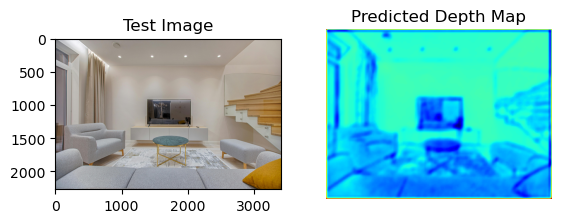

In [6]:
import cv2
import torch
import matplotlib.pyplot as plt

# Load a test RGB image
test_rgb = cv2.imread('test_image_2.jpg')
show_img = test_rgb.copy()
test_rgb = cv2.resize(test_rgb, (640, 480)) / 255.0  # Resize and normalize
test_rgb_tensor = torch.tensor(test_rgb).permute(2, 0, 1).unsqueeze(0).float()

# Predict depth
snapshot_dir = "model_snapshots"
model_path = f"{snapshot_dir}/depth_model_kfold.pth"
model = SimpleDepthCNN()
model.load_state_dict(torch.load(model_path))
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted_depth = model(test_rgb_tensor).squeeze().numpy()

# Display predicted depth map
plt.subplot(1, 2, 1).imshow(cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB))
plt.title("Test Image")
plt.subplot(1, 2, 2).imshow(predicted_depth, cmap='jet')
plt.title("Predicted Depth Map")
plt.axis("off")
plt.show()
